# Técnicas de agrupamiento

## Objetivos

- Entender los métodos de clustering K-means, jerárquico y DBSCAN.
- Generar agrupamientos con los métodos de clustering previamente indicados y realizar una comparativa.
- Investigar sobre una técnica de agrupamiento con un caso de uso concreto.


## Descripción

El conjunto de datos con el cual vamos a trabajar se encuentra en el siguiente enlace: https://www.kaggle.com/datasets/umerrtx/machine-failure-prediction-using-sensor-data

Este conjunto de datos contiene datos de sensores recopilados de varias máquinas, con el objetivo de predecir fallos de las máquinas con antelación. Incluye una variedad de lecturas de sensores, así como las fallas de la máquina registradas.



### Clustering

Comenzamos importando las librerías necesarias y cargando el dataset.

Este archivo contiene 944 mediciones de sensores de diferentes máquinas, contiene una etiqueta de si tiene fallo o no.

Notas:
1. footfall: The number of people or objects passing by the machine.
2. tempMode: The temperature mode or setting of the machine.
3. AQ: Air quality index near the machine.
4. USS: Ultrasonic sensor data, indicating proximity measurements.
5. CS: Current sensor readings, indicating the electrical current usage of the machine.
6. VOC: Volatile organic compounds level detected near the machine.
7. RP: Rotational position or RPM (revolutions per minute) of the machine parts.
8. IP: Input pressure to the machine.
9. Temperature: The operating temperature of the machine.
10. fail: Binary indicator of machine failure (1 for failure, 0 for no failure).

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# se carga el dataset, con separados 
df = pd.read_csv('data.csv', sep=',') 

#### ¿Cuántas instancias tiene el dataset?

In [3]:
##indica aquí tu respuesta
df.shape[0]

944

#### ¿Cuál es el tipo de datos predominante en el dataset?

In [4]:
#Número de valores distintos por columna
df.nunique()

footfall       99
tempMode        8
AQ              7
USS             7
CS              7
VOC             7
RP             71
IP              7
Temperature    24
fail            2
dtype: int64

In [5]:
# Descripción del dataset
df.describe()

,footfall,tempMode,AQ,USS,CS,VOC,RP,IP,Temperature,fail
count,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000
mean,306.381356,3.727754,4.325212,2.939619,5.394068,2.842161,47.043432,4.565678,16.331568,0.416314
std,1082.606745,2.677235,1.438436,1.383725,1.269349,2.273337,16.423130,1.599287,5.974781,0.493208
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,19.000000,1.000000,1.000000,0.000000
25%,1.000000,1.000000,3.000000,2.000000,5.000000,1.000000,34.000000,3.000000,14.000000,0.000000
50%,22.000000,3.000000,4.000000,3.000000,6.000000,2.000000,44.000000,4.000000,17.000000,0.000000
75%,110.000000,7.000000,6.000000,4.000000,6.000000,5.000000,58.000000,6.000000,21.000000,1.000000
max,7300.000000,7.000000,7.000000,7.000000,7.000000,6.000000,91.000000,7.000000,24.000000,1.000000


*   El tipo de dato predominante en el dataset es categórico ordinal discreto, ya que contiene más columnas categóricas (7) en comparación con las continuas (3). 
Gran parte de las variables en este conjunto de datos están representadas por valores numéricos discretos. 

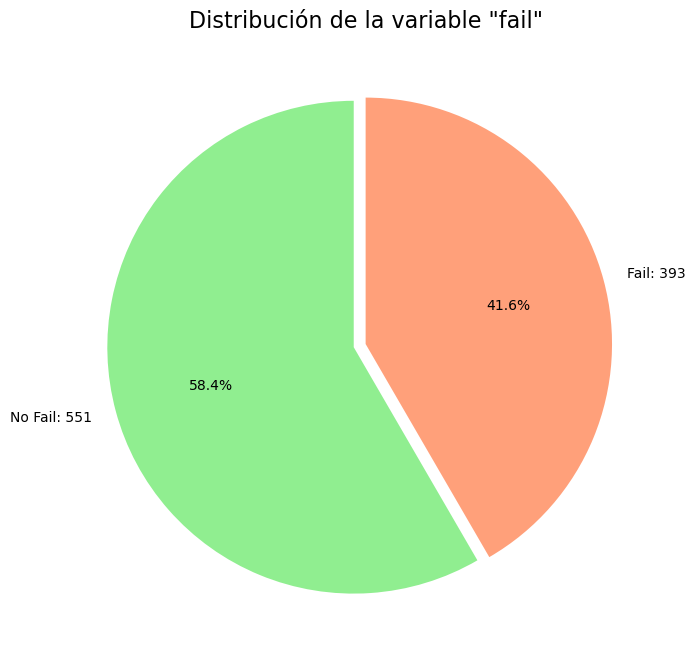

In [6]:
fail_counts = df['fail'].value_counts()
labels = [f'No Fail: {fail_counts[0]}', f'Fail: {fail_counts[1]}']
plt.figure(figsize=(8, 8))
plt.pie(fail_counts, labels=labels, autopct='%1.1f%%', colors=['lightgreen', 'lightsalmon'], startangle=90, explode=(0.05, 0))
plt.title('Distribución de la variable "fail"', fontsize=16)
plt.show()

**Datos predominantes en la variable objetivo:**

*   **No Fail**: Se observa una mayor frecuencia en valores que indican que no hay fallo, con una frecuencia del 58,4% y con un total de 551 casos 
*   **Fail**: Un parción menor que su contraparte No Fail con una frecuencia del 41.6%, con un total de 393 registros.

**Continuas**
*   La feature *footfall* es un atributo discreto con valores entre 0 y 110 en su tercer intercuartil pero con un valor 7.300 en su valor máximo señal de la posibilidad de la existencia de outliers. Otra variable que sigue el mismo caso pero sin la presunta presencia de outliers es la variable RP.
*   Temperature tiene valores continuos numéricos entre 1 y 24 limitando así su rango de valores

**Categóricas (tipo de dato predominante)**

*   Ordinal numérica: tempMode, AQ, USS, CS, VOC, IP; todas són variables categóricas ordinales con un rango entre 0 y 7



*   Categórica binaria: Variable objetivo **fail** valores 0 y 1

#### ¿cuáles son los valores mínimo y máximo de la variable 'RP'?

In [7]:
min_rp = df["RP"].min()
max_rp = df["RP"].max()
print(f"El feature RP tiene un valor mínimo de {min_rp} RPM y con un valor máximo de {max_rp} RPM")


El feature RP tiene un valor mínimo de 19 RPM y con un valor máximo de 91 RPM


**El atributo RP tiene el valor mínimo 19 RPM y el valor máximo es 91 RPM**

#### Para los algoritmos de clustering el dataset no puede tener instancias con datos faltantes.


In [8]:
df.isnull().sum()

footfall       0
tempMode       0
AQ             0
USS            0
CS             0
VOC            0
RP             0
IP             0
Temperature    0
fail           0
dtype: int64

**No se detectan valores faltantes**

#### Elimine la variable fail

In [9]:
#_indica aquí tu respuesta_
y_target = df.fail
y_target
df = df.drop(columns=['fail'])


## tratamiento adicional sobre los datos

##  Paso 1: Analizar outliers
En este paso solo se analizará la distribución de los datos numéricos continuos del dataset y para los datos categóricos ordinales se analiza cual es su frecuencia y distribución para detallar los posibles outliers

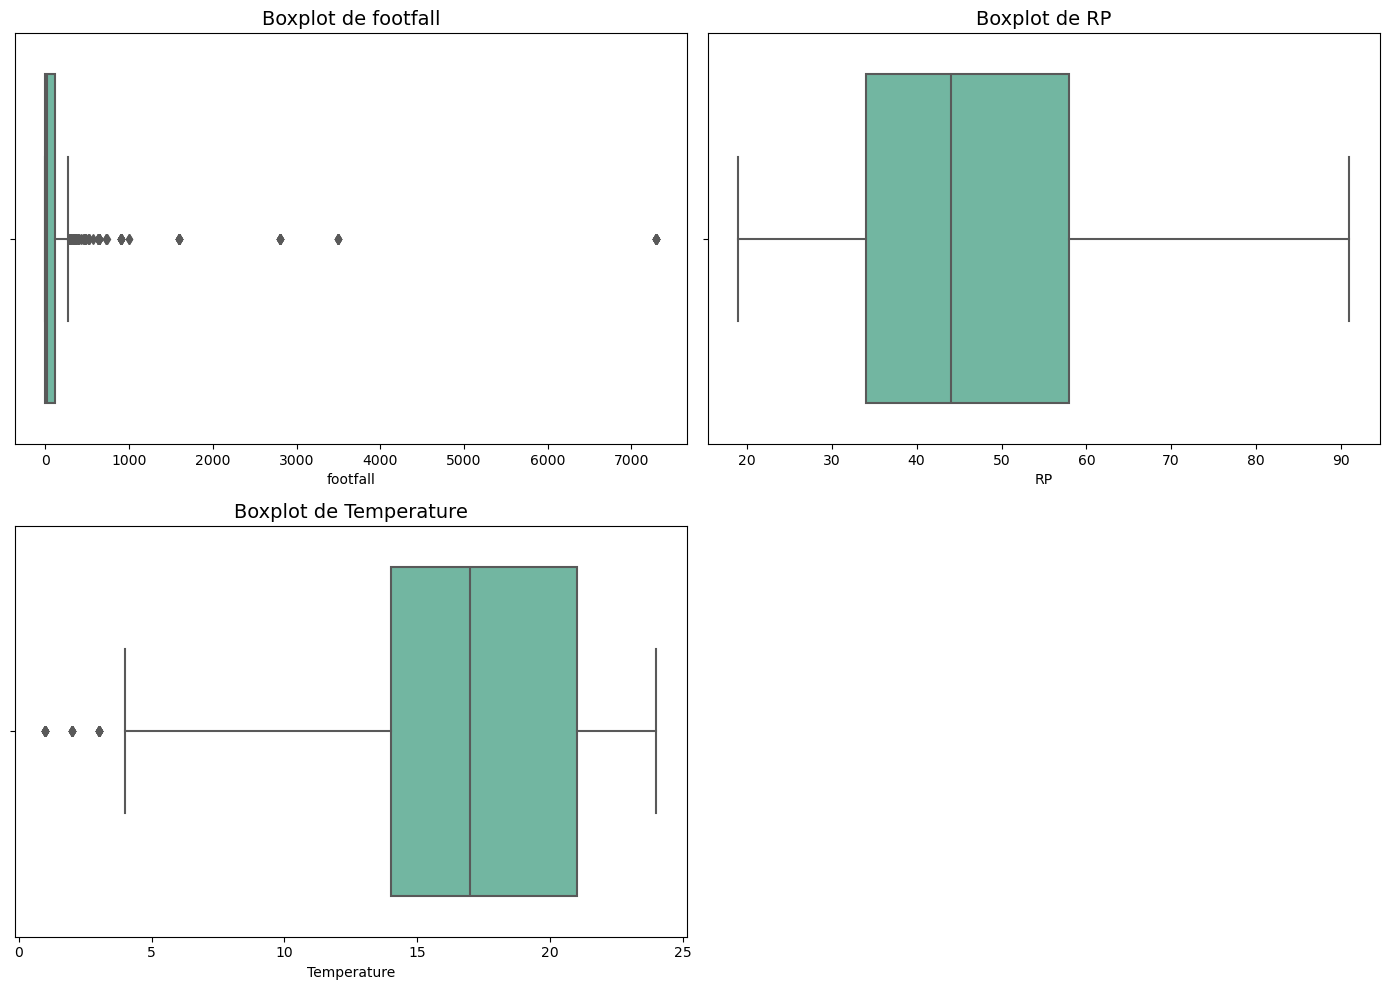

In [10]:
# Configuración para los boxplots
variables = ['footfall', 'RP', 'Temperature']
num_vars = len(variables)  # Número de variables
num_cols = 2  # Número de columnas
num_rows = (num_vars + num_cols - 1) // num_cols  # Calcular el número de filas

plt.figure(figsize=(14, 5 * num_rows))

# Crear boxplots horizontales para cada variable
for i, column in enumerate(variables):
    plt.subplot(num_rows, num_cols, i + 1)  # Subplot para cada variable
    sns.boxplot(x=df[column], palette="Set2")  # Gráfico de boxplot horizontal
    plt.title(f'Boxplot de {column}', fontsize=14)
    plt.xlabel(column)  # Etiqueta en el eje X

plt.tight_layout()  # Ajustar el layout para que no se superpongan
plt.show()

In [11]:
# Calcular el IQR para la variable footfall
Q1 = df['footfall'].quantile(0.25)
Q3 = df['footfall'].quantile(0.75)
IQR = Q3 - Q1

# Calcular el límite superior para detectar outliers
upper_bound = Q3 + 1.5 * IQR
print(f"Límite superior para outliers: {upper_bound}")

# Calcular la media de los valores que no son outliers
non_outliers_mean = df.loc[df['footfall'] <= upper_bound, 'footfall'].median()

# Reemplazar los outliers con la media de los valores no outliers directamente en el DataFrame df
df.loc[df['footfall'] > upper_bound, 'footfall'] = non_outliers_mean

# Mostrar los valores de 'footfall' después del reemplazo de outliers
print("\nValores de 'footfall' después de reemplazar outliers por la media:")
print(df['footfall'])


Límite superior para outliers: 273.5

Valores de 'footfall' después de reemplazar outliers por la media:
0        0.0
1      190.0
2       31.0
3       83.0
4       12.5
       ...  
939      0.0
940      0.0
941      0.0
942      0.0
943     18.0
Name: footfall, Length: 944, dtype: float64


C:\Users\GenisPc\AppData\Local\Temp\ipykernel_10088\450139666.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '12.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['footfall'] > upper_bound, 'footfall'] = non_outliers_mean


Después de analizar los outliers podemos acotar a que solo el atributo footall tiene datos que sobrepasan la distancia intercuartil multiplicado por 1,5 de los datos y que por tanto se detectan como datos que són potencialmente outliers, pero que no pueden ser eliminados dado que representan más del 5% de los datos del dataset. Por lo que seria más optimo el escalado de los datos




--- Análisis de la variable: tempMode ---


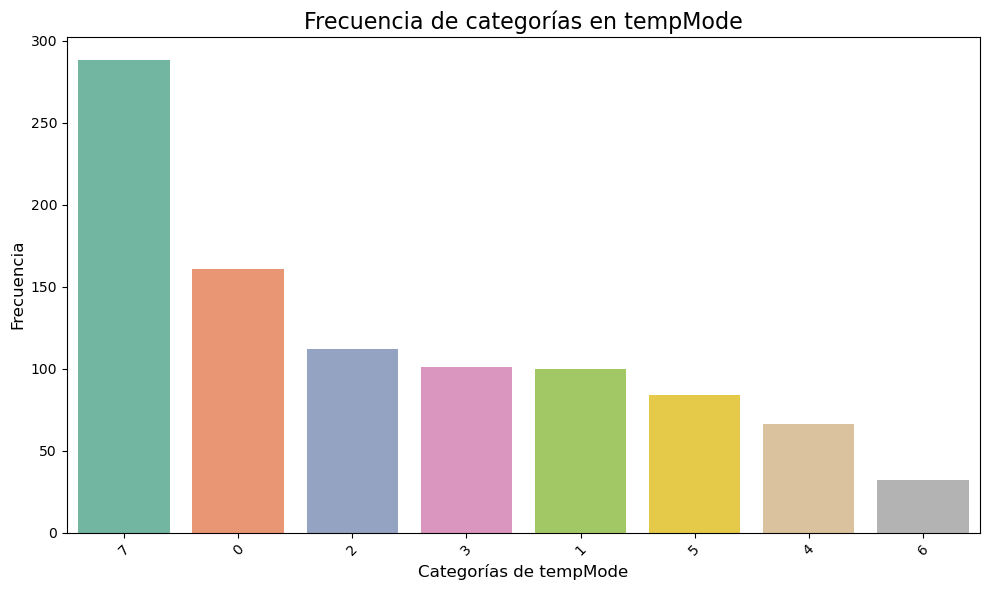


Número exacto de registros por categoría:
tempMode
7    288
0    161
2    112
3    101
1    100
5     84
4     66
6     32
Name: count, dtype: int64

--- Análisis de la variable: AQ ---


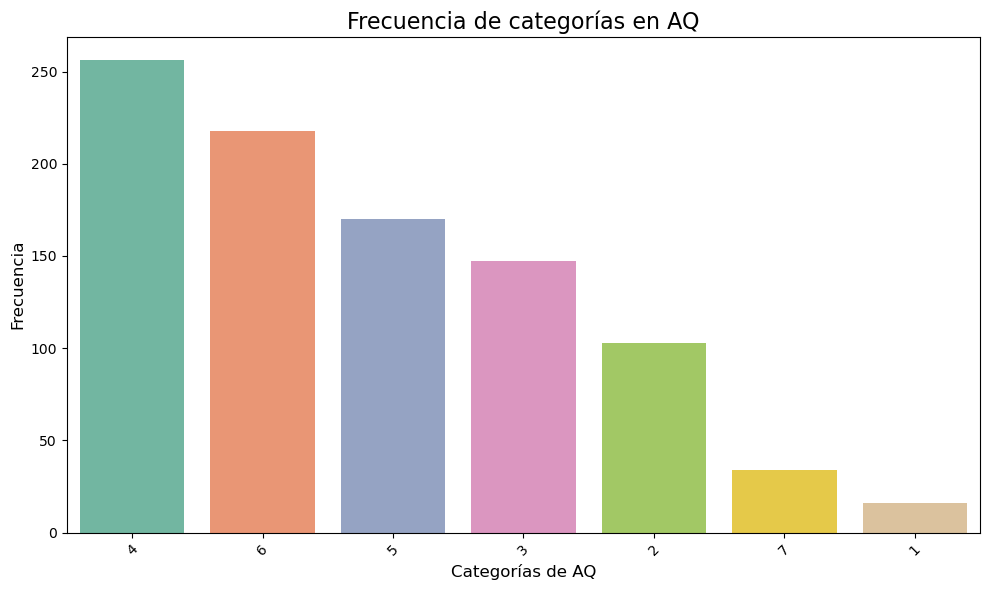


Número exacto de registros por categoría:
AQ
4    256
6    218
5    170
3    147
2    103
7     34
1     16
Name: count, dtype: int64

--- Análisis de la variable: USS ---


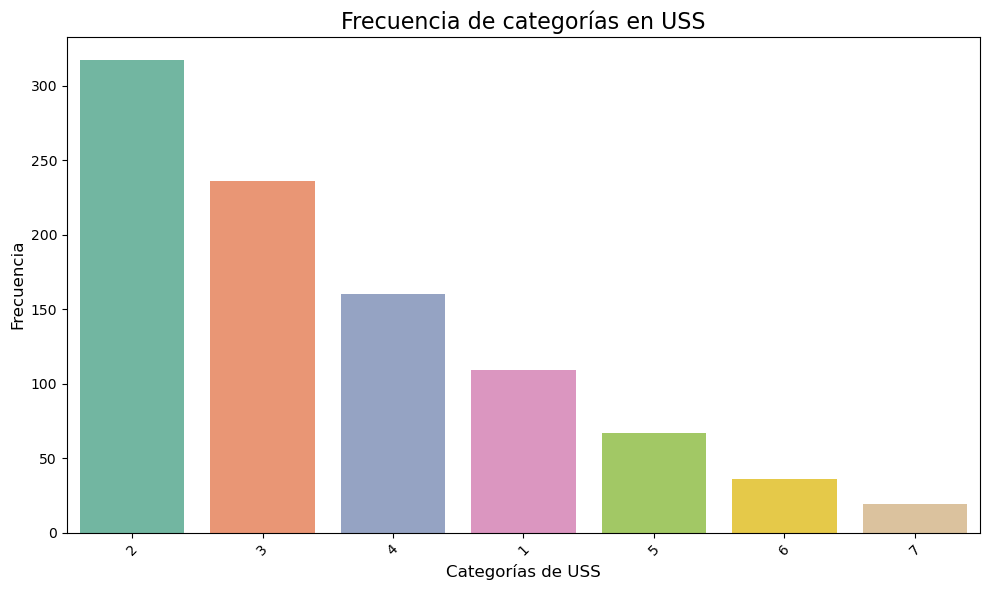


Número exacto de registros por categoría:
USS
2    317
3    236
4    160
1    109
5     67
6     36
7     19
Name: count, dtype: int64

--- Análisis de la variable: CS ---


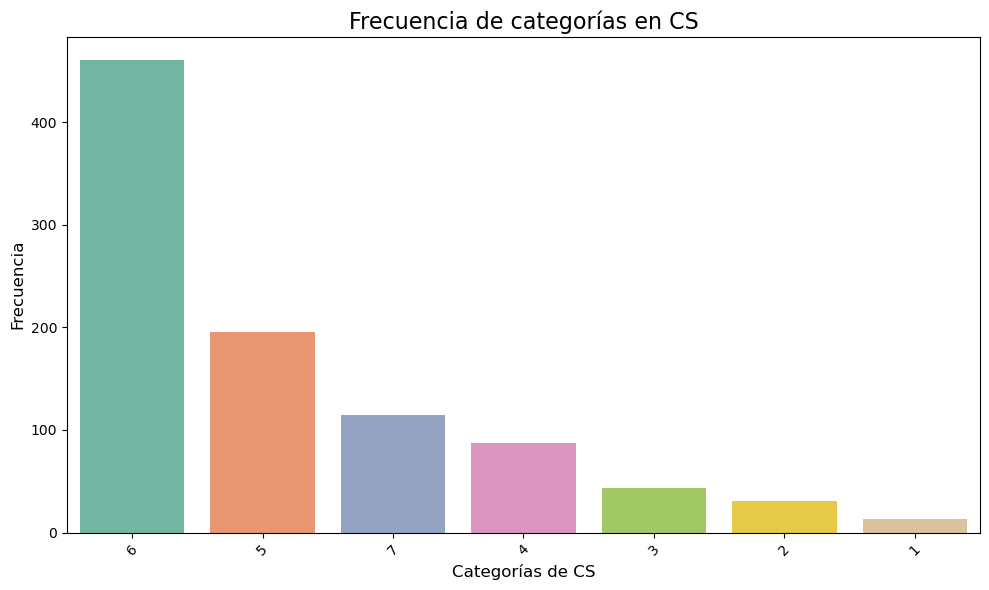


Número exacto de registros por categoría:
CS
6    460
5    195
7    115
4     87
3     43
2     31
1     13
Name: count, dtype: int64

--- Análisis de la variable: VOC ---


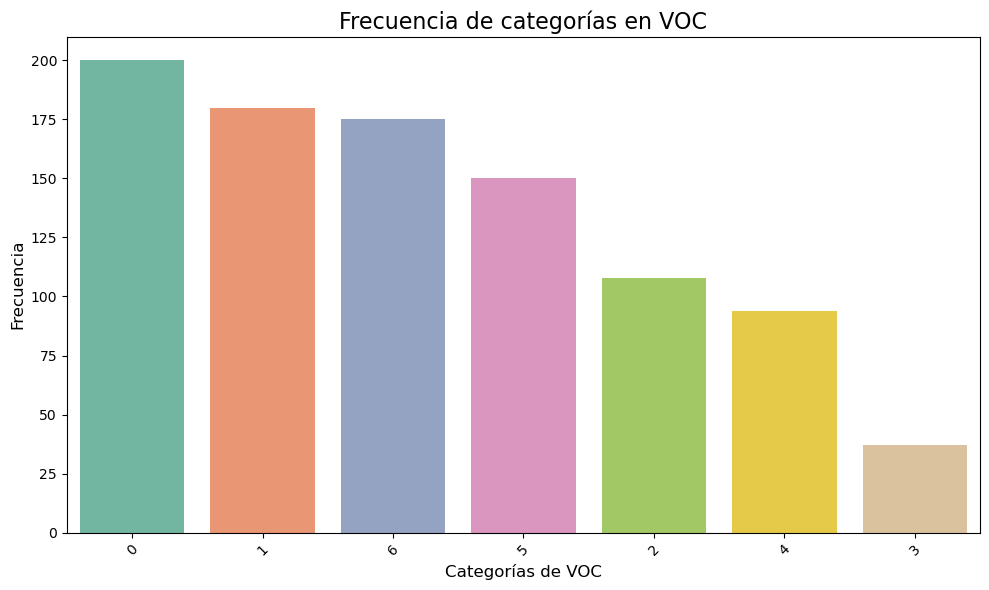


Número exacto de registros por categoría:
VOC
0    200
1    180
6    175
5    150
2    108
4     94
3     37
Name: count, dtype: int64

--- Análisis de la variable: IP ---


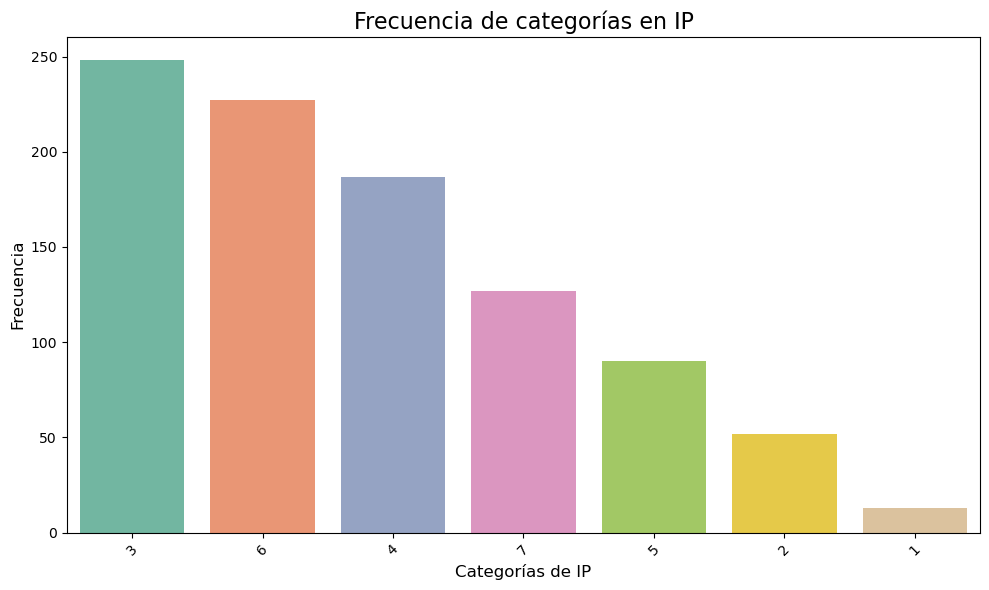


Número exacto de registros por categoría:
IP
3    248
6    227
4    187
7    127
5     90
2     52
1     13
Name: count, dtype: int64


In [12]:
# Lista de variables categóricas ordinales a analizar
variables_ordinales = ['tempMode', 'AQ', 'USS', 'CS', 'VOC', 'IP']

# Análisis de cada variable categórica ordinal
for var in variables_ordinales:
    print(f"\n--- Análisis de la variable: {var} ---")
      
    # Visualización de la frecuencia de categorías
    plt.figure(figsize=(10, 6))
    sns.countplot(x=var, data=df, palette='Set2', order=df[var].value_counts().index)
    plt.title(f'Frecuencia de categorías en {var}', fontsize=16)
    plt.xlabel(f'Categorías de {var}', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Imprimir número exacto de registros
    print("\nNúmero exacto de registros por categoría:")
    print(df[var].value_counts())


Observando las frecuencias de nuestros datos categóricos ordinales no se detectan categorías extrañas entre los datos es decir se observan claramente clases con menos frecuencia para es un comportamiento que se comparte con el resto de los datos motivo por el cual no se van a considerar outliers

##  Paso 2: Escalado de los datos

In [13]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df.values)

# Algoritmos

## K-Means

Crea 10 modelos de KMeans y entrénalos. Haciendo uso del método indicado para saber el número ideal de clústeres.

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

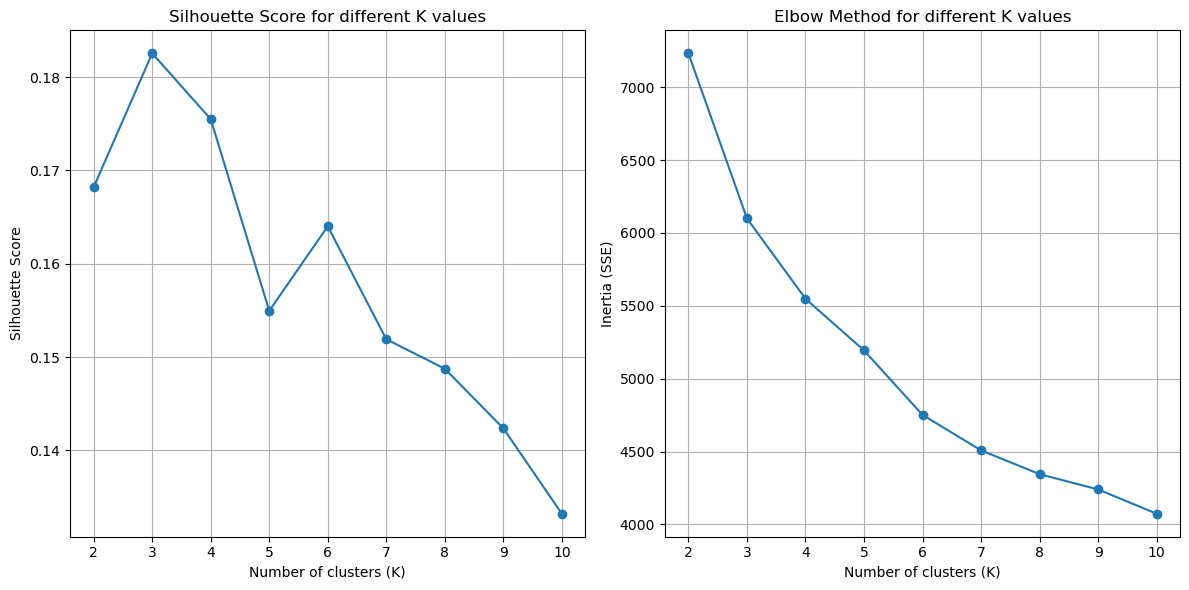

Optimal number of clusters: 3


In [14]:
# Parámetros
max_k = 10

silhouette_scores = []
inertia_scores = [] 
K_values = range(2, max_k + 1)
kmeans_list = []


# Probar diferentes valores de K (número de clústeres)
for K in K_values:
    kmeans = KMeans(n_clusters=K, init='random', n_init=1, random_state=42)
    kmeans.fit(data_scaled)
    kmeans_list.append(kmeans)
    
    # Obtener las etiquetas y calcular el silhouette score
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(data_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    # Guardar la inercia (SSE)
    inertia_scores.append(kmeans.inertia_)

# Graficar los silhouette scores para cada valor de K
plt.figure(figsize=(12, 6))

# Subplot 1: Silhouette Scores
plt.subplot(1, 2, 1)
plt.plot(K_values, silhouette_scores, marker='o')
plt.title('Silhouette Score for different K values')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)

# Subplot 2: Método del Codo (inercia)
plt.subplot(1, 2, 2)
plt.plot(K_values, inertia_scores, marker='o')
plt.title('Elbow Method for different K values')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia (SSE)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Encontrar el K óptimo (mayor silhouette score)
optimal_k = K_values[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_k}")

# Recuperar el modelo KMeans con el K óptimo
optimal_kmeans = kmeans_list[np.argmax(silhouette_scores)]



Ahora toca interpretar lo que Kmeans ha realizado. Recordemos que el objetivo de KMeans es encontrar patrones en los datos.

Lo primero que vamos a realizar es un gráfico para visualizar los clústers que ha creado con base en las variables utilizadas para crearlos.

In [15]:
import plotly.express as px

clusters = pd.DataFrame(data_scaled,columns=df.columns)
clusters['label'] = optimal_kmeans.labels_
polar = clusters.groupby("label").mean().reset_index()
polar = pd.melt(polar,id_vars=["label"])
fig4 = px.line_polar(polar, r="value", theta="variable", color="label", line_close=False,height=800,width=600)
fig4.show()

## DBSCAN

In [16]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

#### búsqueda de los mejores hiperparámetros para el algoritmo

Para la búsqueda de los mejores hiperparámetros aplicaré la técnica publicada por los creadores del algoritmo:
https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

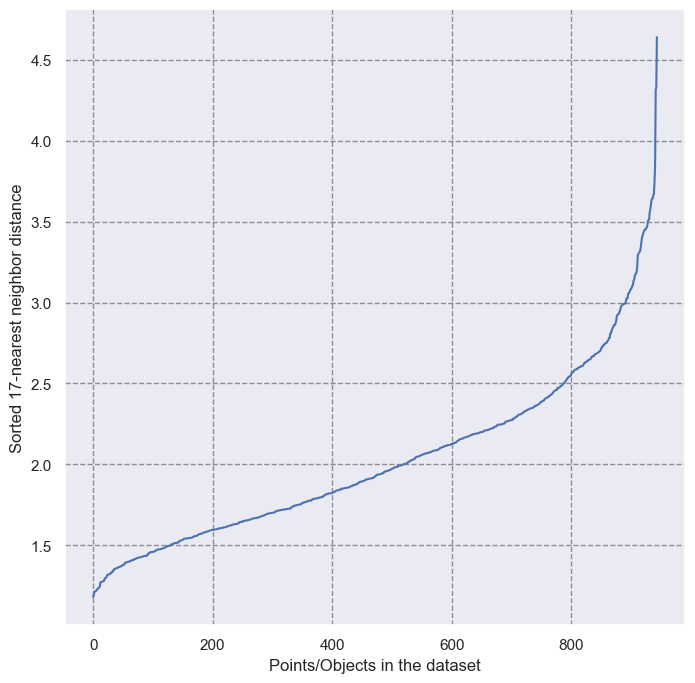

In [ ]:

def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):

    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)

    # For each point, compute distances to its k-nearest neighbors
    distances, indices = nbrs.kneighbors(X) 
                                       
    distances = np.sort(distances, axis=0)
    distances = distances[:, k-1]

    # Plot the sorted K-nearest neighbor distance for each point in the dataset
    plt.figure(figsize=(8,8))
    plt.plot(distances)
    plt.xlabel('Points/Objects in the dataset', fontsize=12)
    plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
    plt.grid(True, linestyle="--", color='black', alpha=0.4)
    plt.show()
    plt.close()


k = 2 * data_scaled.shape[-1] - 1 
get_kdist_plot(X=data_scaled, k=k)


Del gráfico anterior se puede inferir que el valor óptimo eps se puede suponer en alrededor de 2.75 para el conjunto de datos dado.

**min_samples**
Para la definición de Min seguiré una pauta general para elegir el valor óptimo de este hiperparámetros es que debe establecerse en el doble del número de características ( Sander et al. 1998 https://link.springer.com/article/10.1023/A:1009745219419 ). En este caso el número de características es de 8 por lo tanto min_samples tendría un valor de 16 pero vemos de forma estocástica para un rango definido de min_samples

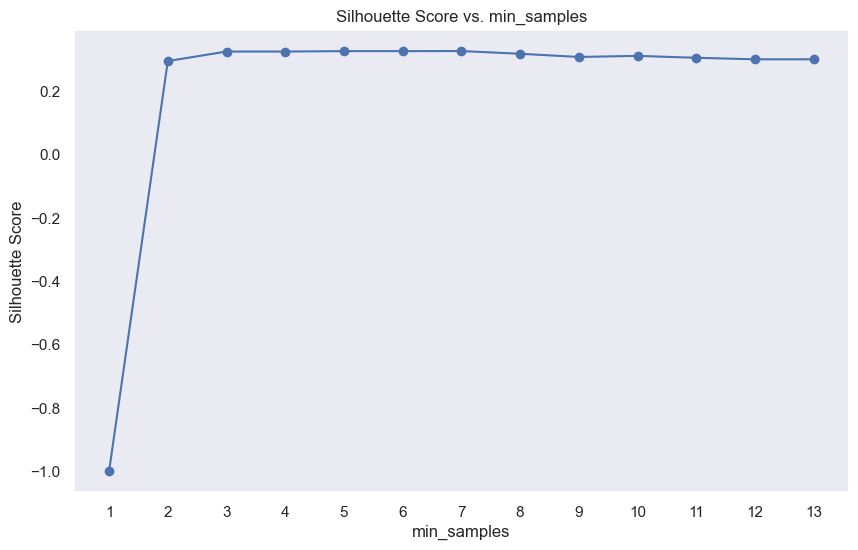

In [19]:
min_samples_range = range(1, 14)  
silhouette_scores = []

for min_samples in min_samples_range:
    dbscan = DBSCAN(eps=2.75, min_samples=min_samples)
    labels = dbscan.fit_predict(data_scaled)
    
    # Calcular el Silhouette Score si hay más de un cluster
    if len(set(labels)) > 1 and -1 in labels:
        score = silhouette_score(data_scaled, labels)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(-1)  # Si no hay clusters válidos


plt.figure(figsize=(10, 6))
plt.plot(min_samples_range, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. min_samples')
plt.xlabel('min_samples')
plt.ylabel('Silhouette Score')
plt.xticks(min_samples_range)
plt.grid()
plt.show()


El número correcto de min_samples es **2** gracias al resultado presente en el gráfico, dado que se visualiza en la pendiente una curva que cambia drásticamente, formando un "codo". Este punto puede  representar un valor apropiado para min_samples.

In [20]:
#### Entrenar el algoritmo DBSCAN con los hiperparámetros encontrados

In [21]:
# Crear el modelo DBSCAN
dbscan = DBSCAN(eps=2.75, min_samples=2)
dbscan.fit(data_scaled)

DBSCAN(eps=2.75, min_samples=2)

#### Elegir dos variables para visualizar los clústeres

In [23]:
plt.figure(figsize=(10, 6))
labels = dbscan.fit_predict(data_scaled)
unique_labels = np.unique(labels)

<Figure size 1000x600 with 0 Axes>

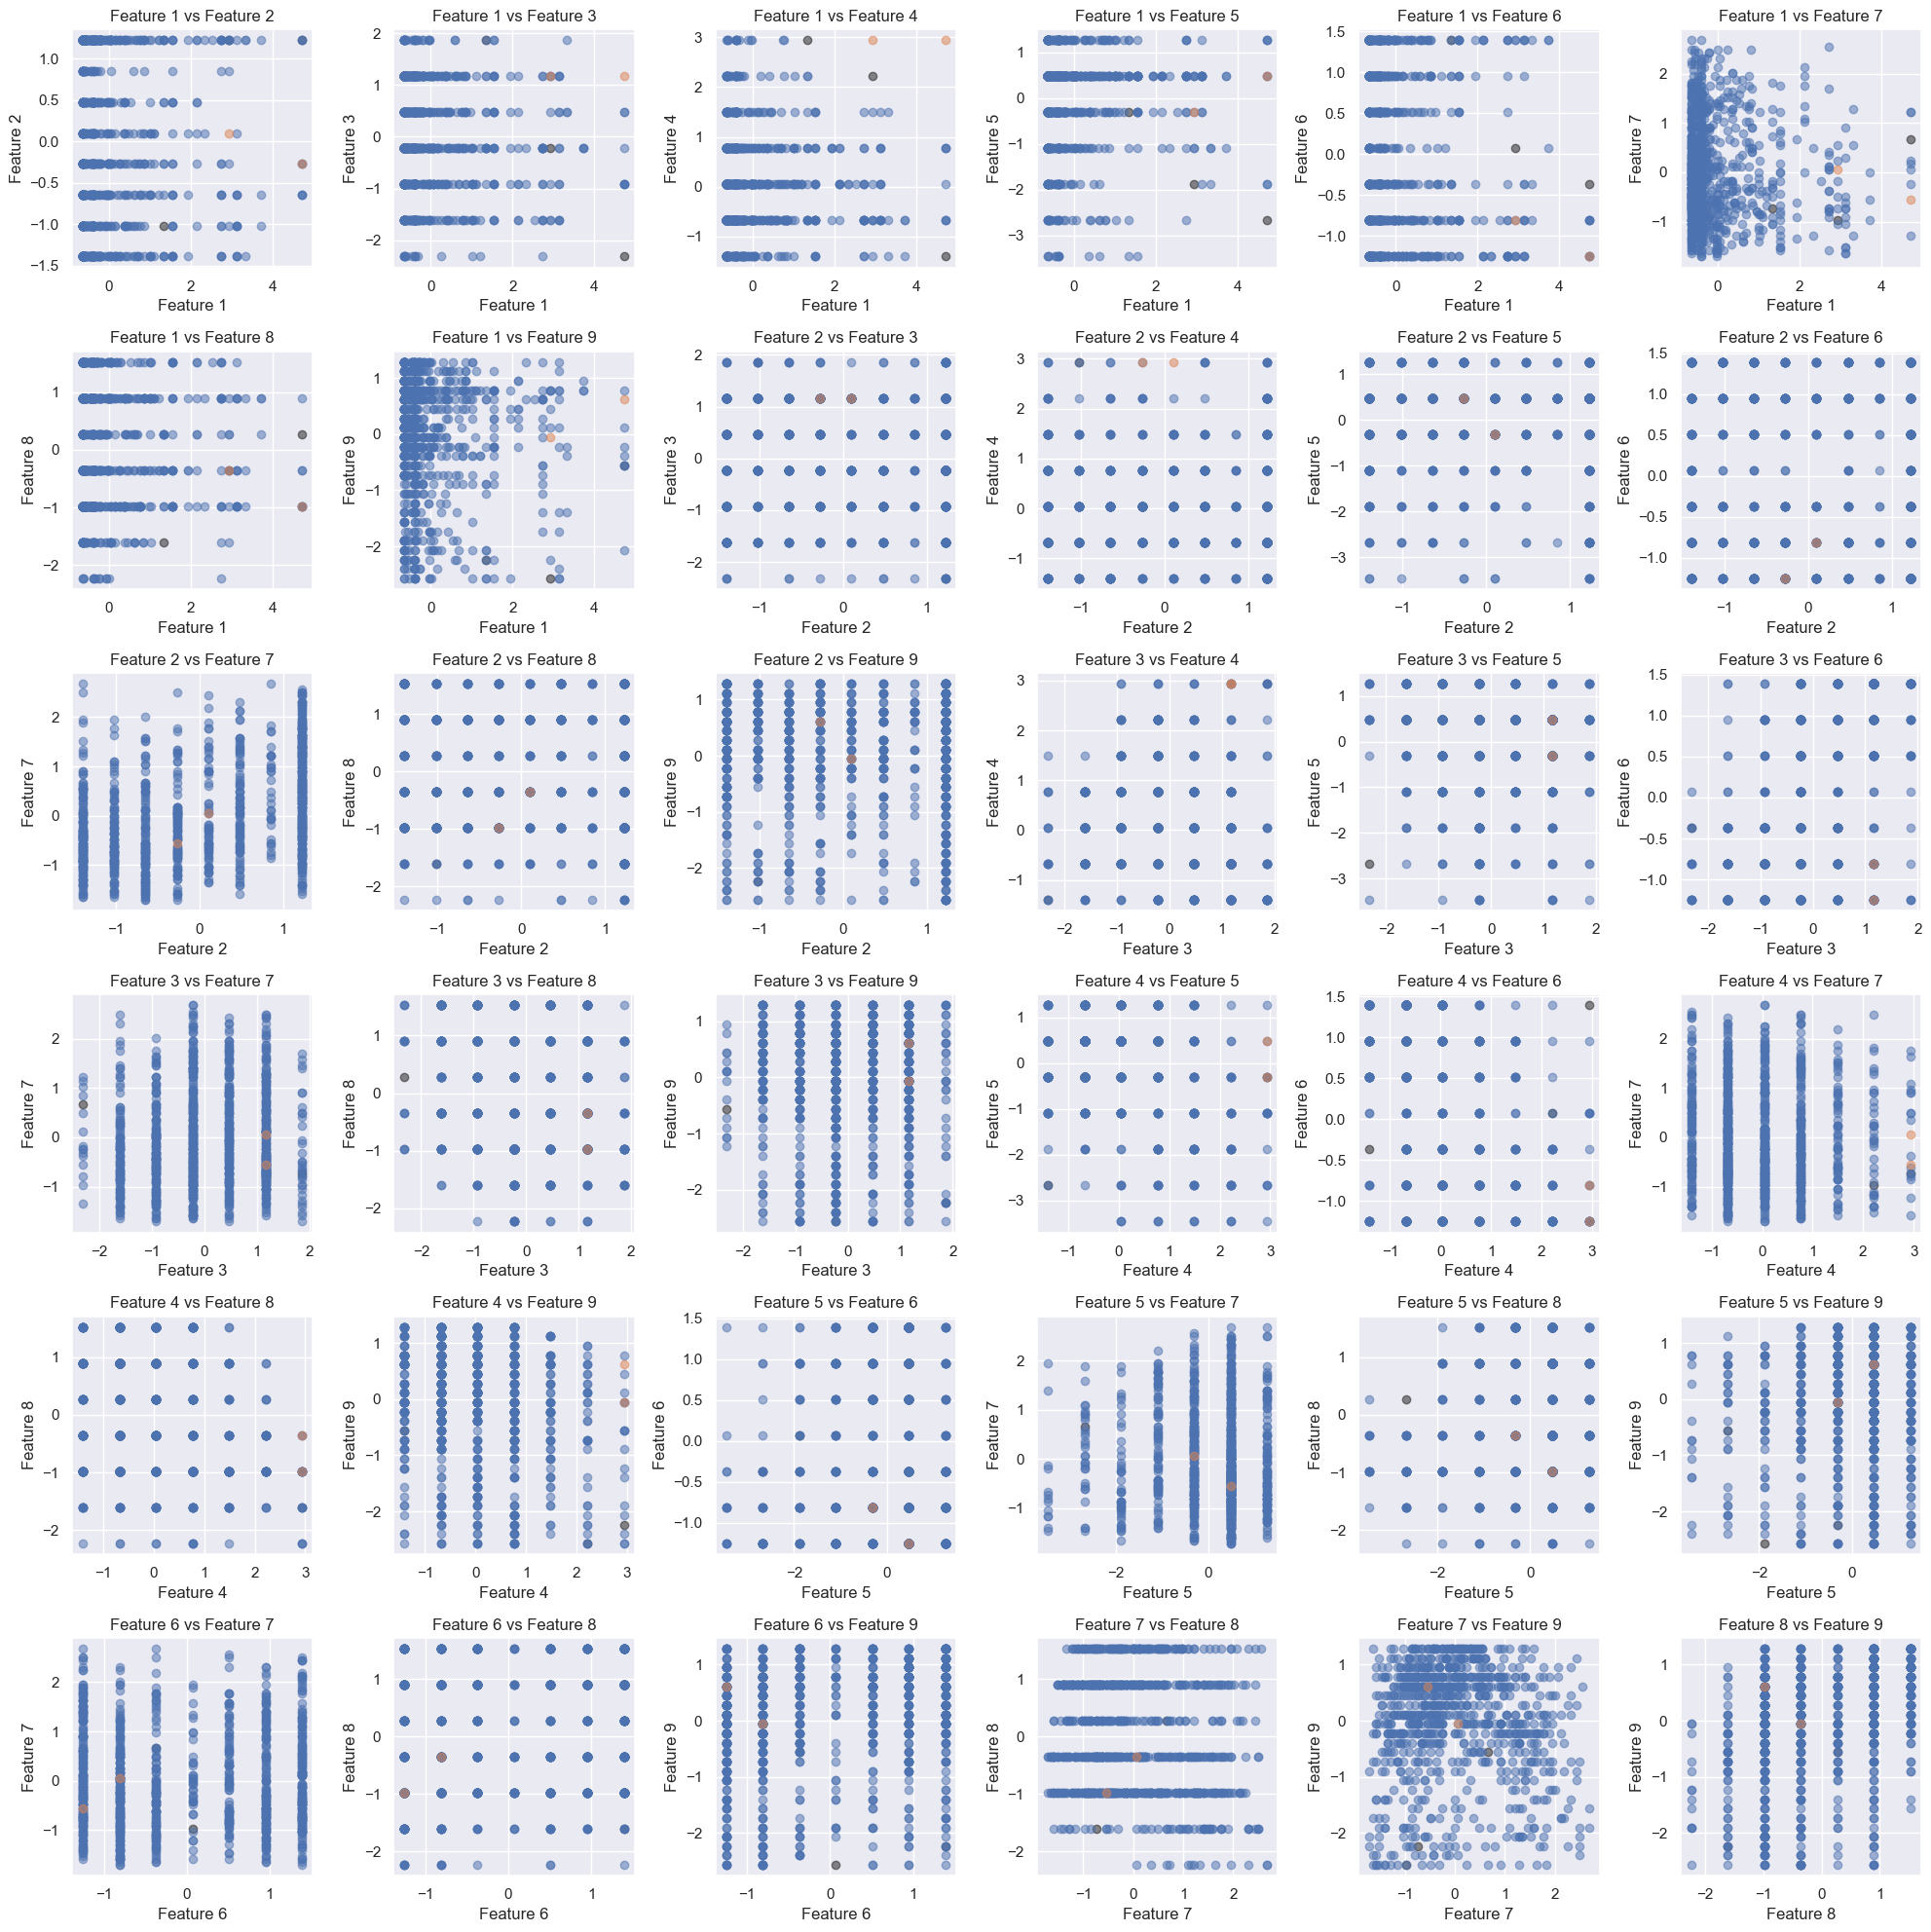

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations


n_features = 9

# Crear todas las combinaciones de dos features
combinations_of_features = list(combinations(range(n_features), 2))

# Crear una figura grande para contener los subplots
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(20, 20))
axes = axes.ravel()  # Desenrollar los subplots en una sola lista

for i, (feature1, feature2) in enumerate(combinations_of_features):
    ax = axes[i]
    
    # Graficar cada combinación de pares de features
    for label in unique_labels:
        if label == -1:
            ax.scatter(data_scaled[labels == label, feature1], 
                       data_scaled[labels == label, feature2], 
                       color='k', label='Ruido', alpha=0.5)
        else:
            ax.scatter(data_scaled[labels == label, feature1], 
                       data_scaled[labels == label, feature2], 
                       label=f'Cluster {label}', alpha=0.5)

    # Etiquetar los ejes con el número de las features
    ax.set_title(f'Feature {feature1 + 1} vs Feature {feature2 + 1}')
    ax.set_xlabel(f'Feature {feature1 + 1}')
    ax.set_ylabel(f'Feature {feature2 + 1}')

# Ajustar la separación entre subplots
plt.tight_layout()
plt.show()


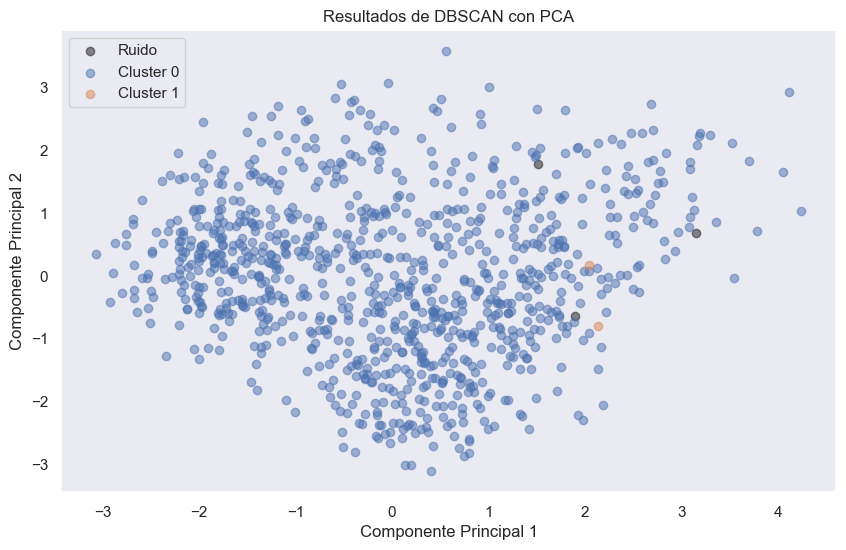

Cargas de las características en las primeras dos componentes principales:
   Feature 1  Feature 2  Feature 3  Feature 4  Feature 5  Feature 6  \
0   0.118632   0.096796  -0.351391   0.491159  -0.270425  -0.532194   
1  -0.168870   0.341268   0.497268   0.014270  -0.261774   0.320832   

   Feature 7  Feature 8  Feature 9  
0   0.065948  -0.314944  -0.389801  
1   0.457208  -0.407720  -0.246588  


In [25]:
from sklearn.decomposition import PCA

# Aplicar PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

# Crear un DataFrame con las características reducidas y las etiquetas
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
df_pca['Cluster'] = labels

# Visualizar los resultados
plt.figure(figsize=(10, 6))
unique_labels = np.unique(labels)

for label in unique_labels:
    if label == -1:
        plt.scatter(df_pca[df_pca['Cluster'] == label]['PC1'], 
                    df_pca[df_pca['Cluster'] == label]['PC2'], 
                    color='k', label='Ruido', alpha=0.5)
    else:
        plt.scatter(df_pca[df_pca['Cluster'] == label]['PC1'], 
                    df_pca[df_pca['Cluster'] == label]['PC2'], 
                    label=f'Cluster {label}', alpha=0.5)

plt.title('Resultados de DBSCAN con PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid()
plt.show()

# Paso 2: Obtener las componentes principales (cargas de las características)
pca_components = pd.DataFrame(pca.components_, columns=[f'Feature {i+1}' for i in range(data_scaled.shape[1])])

# Paso 3: Mostrar la importancia de cada feature en las primeras dos componentes principales
print("Cargas de las características en las primeras dos componentes principales:")
print(pca_components.iloc[:2])  # Mostrar las dos primeras componentes principales


<h1>Conclusión DBSCAN</h1>

El análisis de las cargas de las componentes principales de PCA revela que la Feature 4 (USS) tiene la mayor contribución en la Componente Principal 1 (0.491), indicando su importancia en la separación de los clusters, mientras que Feature 3 (0.497) se destaca en la Componente Principal 2. Aunque Feature 1 (Footfall) muestra una carga menor (0.118 en PC1 y -0.169 en PC2), su combinación con Feature 4 fue mucho más representativa de los clusters en la representación visual en el análisis de DBSCAN, sugiriendo que, a pesar de no ser la más influyente a nivel global, sigue siendo relevante para la identificación de la estructura de los datos. En resumen, Feature 4 es clave para entender la variabilidad en los datos y su relación con los clusters, mientras que Feature 1 (footfall) complementa la separación observada.

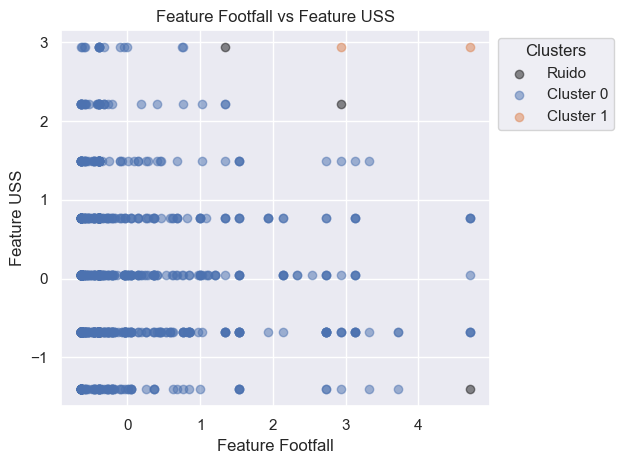

In [26]:
# Graficar el atributo 1 vs atributo 4
for label in unique_labels:
    if label == -1:
        plt.scatter(data_scaled[labels == label, 0], 
                    data_scaled[labels == label, 3], 
                    color='k', label='Ruido', alpha=0.5)
    else:
        plt.scatter(data_scaled[labels == label, 0], 
                    data_scaled[labels == label, 3], 
                    label=f'Cluster {label}', alpha=0.5)

# Etiquetar los ejes
plt.title(f'Feature Footfall vs Feature USS')
plt.xlabel(f'Feature Footfall')
plt.ylabel(f'Feature USS')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Clusters')
plt.tight_layout()
plt.show()

## Dendrograma 

In [ ]:

Agglomerative_model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward')
Agglomerative_model = Agglomerative_model.fit(data_scaled)

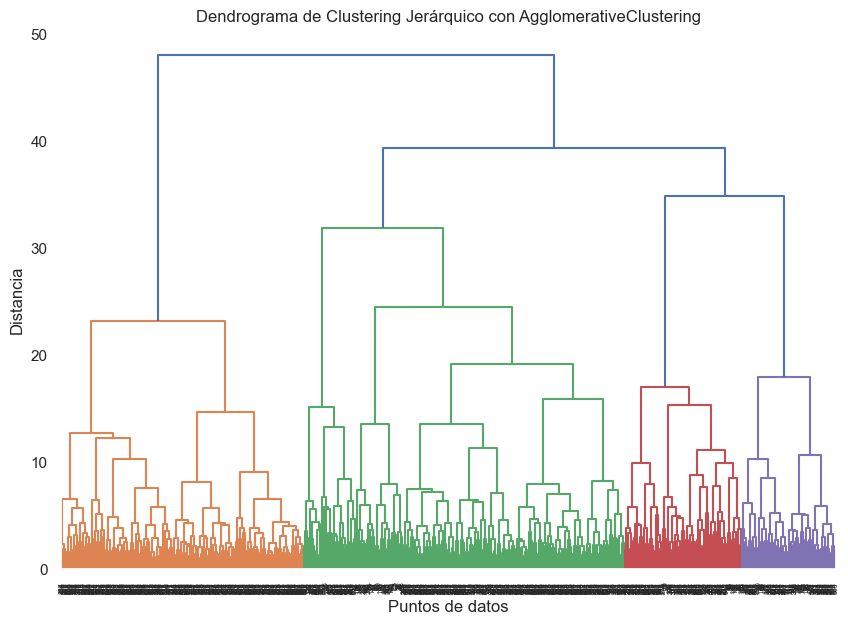

Distancia de fusión al pasar de K=2 a K=1: 47.9927875001161
Distancia de fusión al pasar de K=3 a K=2: 39.35323702430066
Distancia de fusión al pasar de K=4 a K=3: 34.84831763743551
Distancia de fusión al pasar de K=5 a K=4: 31.84118948681397


In [ ]:
# análisis de cuál es el número ideal de clústeres 
agglomerativelabels = Agglomerative_model.labels_

# Usar la matriz de linkage que se puede generar a partir del modelo de clustering
Z = linkage(data_scaled, method='ward')

# Mostrar el dendograma
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Dendrograma de Clustering Jerárquico con AgglomerativeClustering')
plt.xlabel('Puntos de datos')
plt.ylabel('Distancia')
plt.show()

# Imprimir las distancias
print(f"Distancia de fusión al pasar de K=2 a K=1: {Z[-1, 2]}")  # Distancia para K=1
print(f"Distancia de fusión al pasar de K=3 a K=2: {Z[-2, 2]}") # Distancia para pasar de K=3 a K=2
print(f"Distancia de fusión al pasar de K=4 a K=3: {Z[-3, 2]}")  # Distancia para pasar de K=4 a K=3
print(f"Distancia de fusión al pasar de K=5 a K=4: {Z[-4, 2]}")  # Distancia para pasar de K=5 a K=4




In [ ]:
agglomerativelabels = Agglomerative_model.labels_

# Usar la matriz de linkage que se puede generar a partir del modelo de clustering
Z = linkage(data_scaled, method='ward')

# Mostrar el dendograma
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Dendrograma de Clustering Jerárquico con AgglomerativeClustering')
plt.xlabel('Puntos de datos')
plt.ylabel('Distancia')
plt.show()

# Imprimir las distancias
print(f"Distancia de fusión al pasar de K=2 a K=1: {Z[-1, 2]}")  # Distancia para K=1
print(f"Distancia de fusión al pasar de K=3 a K=2: {Z[-2, 2]}") # Distancia para pasar de K=3 a K=2
print(f"Distancia de fusión al pasar de K=4 a K=3: {Z[-3, 2]}")  # Distancia para pasar de K=4 a K=3
print(f"Distancia de fusión al pasar de K=5 a K=4: {Z[-4, 2]}")  # Distancia para pasar de K=5 a K=4




Cón un clustering de k=2 tenemos el salto a una distancia que separa mejor nuestros cluster pasando de 39,35 a 47,99 una distancia de 8,64 que es mayor que el salto anterior (de 3 a 2 clusters) con una distancia aproximada de 5. Por lo tanto el número de clústeres adecuado para entrenar el modelo jerárquico es de 2.

#### dataframe con los datos y las etiquetas otorgadas por el algoritmo.

In [31]:
# Now, decide the number of clusters based on the dendrogram
optimal_clusters = 2
Agglomerative_model = AgglomerativeClustering(n_clusters=optimal_clusters, linkage='ward')
cluster_labels = Agglomerative_model.fit_predict(data_scaled)

# Add cluster labels to the original data
df['cluster'] = cluster_labels
df['label'] = y_target

In [32]:
df[['label', 'cluster']].value_counts()

label  cluster
0      0          520
1      1          265
       0          128
0      1           31
Name: count, dtype: int64

## Análisis

#### Realiza un análisis detallado de cada uno de los grupos generados por los algoritmos aplicados anteriormente y decide cuál es el mejor método para el conjunto de datos. 
Para este análisis se realizara dos apartados el primero una comparativa de métricas entre los clusters generados por cada algoritmo y en un segundo apartado comparativa de las predicciones con la variable fail para de esta forma comparar las predicciones

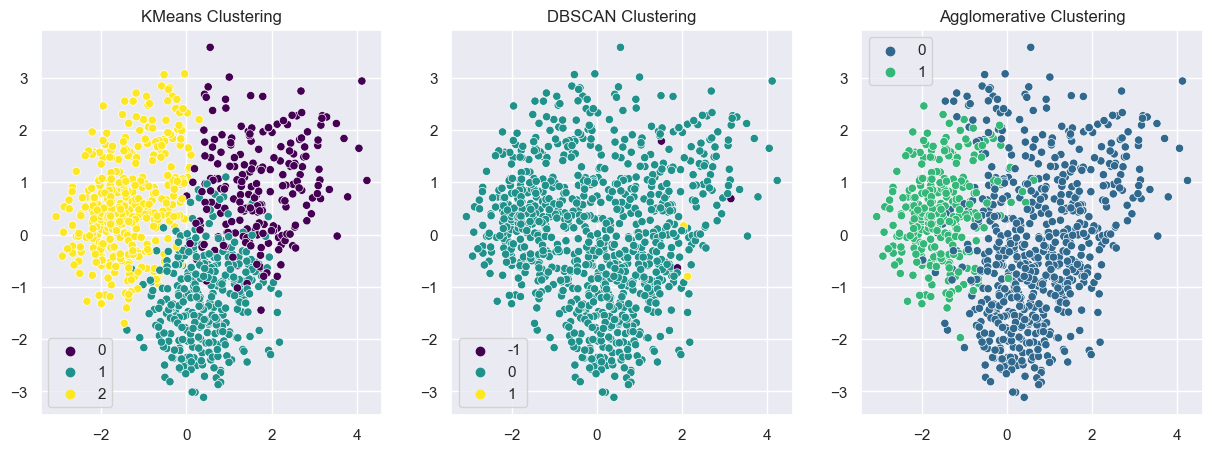

In [33]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data_scaled)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# KMeans
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=optimal_kmeans.labels_, ax=axes[0], palette="viridis")
axes[0].set_title("KMeans Clustering")

# DBSCAN
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=dbscan.labels_, ax=axes[1], palette="viridis")
axes[1].set_title("DBSCAN Clustering")

# Agglomerative Clustering
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=Agglomerative_model.labels_, ax=axes[2], palette="viridis")
axes[2].set_title("Agglomerative Clustering")

plt.show()

In [34]:
# Evaluación para cada método
metrics = {}
for name, labels in zip(["KMeans", "DBSCAN", "Agglomerative"], [optimal_kmeans.labels_, dbscan.labels_, Agglomerative_model.labels_]):
    metrics[name] = {
        "Silhouette Score": silhouette_score(data_scaled, labels),
        "Davies-Bouldin Index": davies_bouldin_score(data_scaled, labels),
        "Calinski-Harabasz Index": calinski_harabasz_score(data_scaled, labels)
    }

import pandas as pd
print(pd.DataFrame(metrics).T)

               Silhouette Score  Davies-Bouldin Index  Calinski-Harabasz Index
KMeans                 0.182538              1.882520               184.805623
DBSCAN                 0.295177              1.393907                 5.862289
Agglomerative          0.117559              2.097208               147.713340


### Resumen de Comparación de Clustering: Métricas

Según los resultados de las métricas muestran que **DBSCAN** es el mejor algoritmo en términos de cohesión y separación de clusters, obteniendo mejores resultados en **Silhouette Score** (0.295) y **Davies-Bouldin Index** (1.394), lo que sugiere clusters compactos y bien separados dato que se ve correctamente en su correspondiente apartado donde se veía la separación de clusters por la variable footfall y USS. **KMeans** destaca en el **Calinski-Harabasz Index** (184.81), indicando una buena dispersión entre clusters y cohesión interna, lo cual es útil para datos estructurados y con clusters aproximadamente esféricos. **Agglomerative Clustering** presenta los puntajes más bajos en las tres métricas, sugiriendo una menor calidad de clustering en este conjunto de datos. En resumen, **DBSCAN** es recomendable si la prioridad es la separación y la flexibilidad en la forma de los clusters, mientras que **KMeans** podría ser mejor para clusters bien definidos y estructurados.


In [35]:
from sklearn.metrics import adjusted_rand_score, v_measure_score, homogeneity_score, completeness_score, fowlkes_mallows_score

optimal_kmeans.labels_
dbscan.labels_
Agglomerative_model.labels_
# Crear un diccionario para almacenar los resultados de cada algoritmo
comparacion_resultados = {}

# Definir una función para calcular las métricas
def calcular_metricas(y_true, y_pred):
    return {
        "ARI": adjusted_rand_score(y_true, y_pred),
        "V-Measure": v_measure_score(y_true, y_pred),
        "Homogeneity": homogeneity_score(y_true, y_pred),
        "Completeness": completeness_score(y_true, y_pred),
        "Fowlkes-Mallows": fowlkes_mallows_score(y_true, y_pred)
    }

# Calcular las métricas para cada conjunto de etiquetas de clustering
comparacion_resultados["KMeans"] = calcular_metricas(y_target, optimal_kmeans.labels_)
comparacion_resultados["DBSCAN"] = calcular_metricas(y_target, dbscan.labels_)
comparacion_resultados["Agglomerative"] = calcular_metricas(y_target, Agglomerative_model.labels_)

# Mostrar los resultados en un DataFrame para comparación
import pandas as pd
resultados_df = pd.DataFrame(comparacion_resultados).T
print(resultados_df)


                    ARI  V-Measure  Homogeneity  Completeness  Fowlkes-Mallows
KMeans         0.427283   0.403893     0.520582      0.329937         0.677912
DBSCAN        -0.002973   0.007997     0.004214      0.078178         0.711774
Agglomerative  0.437057   0.357861     0.342801      0.374305         0.741940


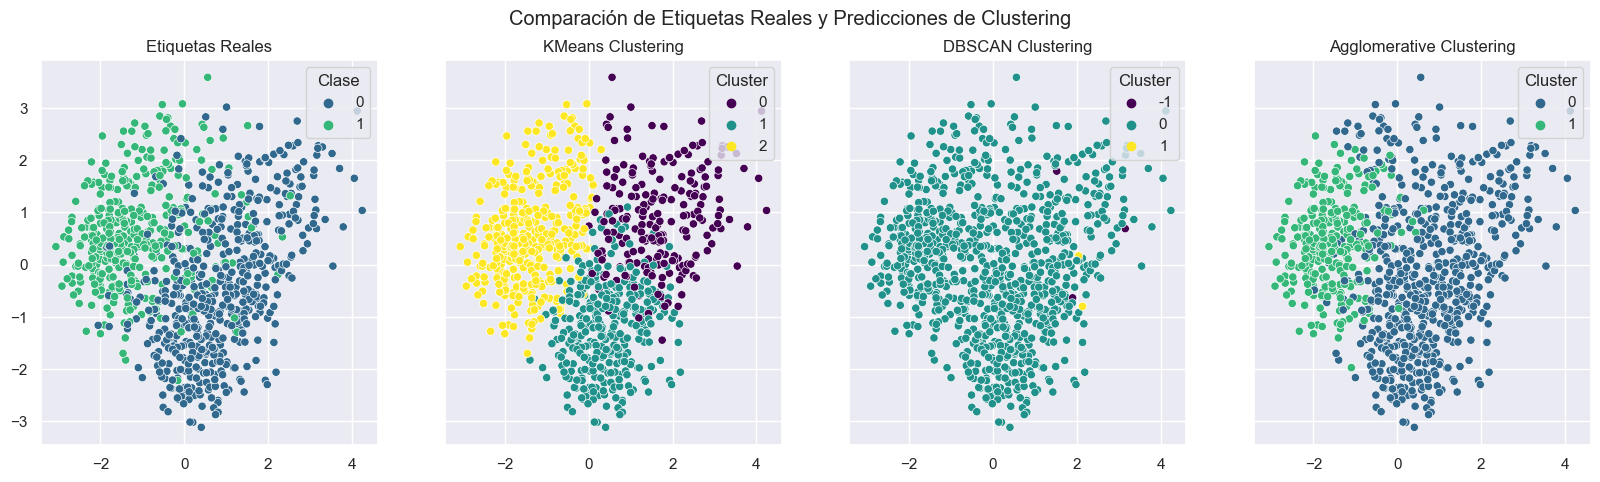

In [36]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)

# Gráfico de etiquetas reales
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_target, ax=axes[0], palette="viridis", legend="full")
axes[0].set_title("Etiquetas Reales")
axes[0].legend(title="Clase", loc='upper right')

# Gráfico de KMeans
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=optimal_kmeans.labels_, ax=axes[1], palette="viridis", legend="full")
axes[1].set_title("KMeans Clustering")
axes[1].legend(title="Cluster", loc='upper right')

# Gráfico de DBSCAN
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue= dbscan.labels_, ax=axes[2], palette="viridis", legend="full")
axes[2].set_title("DBSCAN Clustering")
axes[2].legend(title="Cluster", loc='upper right')

# Gráfico de Agglomerative Clustering
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=Agglomerative_model.labels_, ax=axes[3], palette="viridis", legend="full")
axes[3].set_title("Agglomerative Clustering")
axes[3].legend(title="Cluster", loc='upper right')

plt.suptitle("Comparación de Etiquetas Reales y Predicciones de Clustering")
plt.show()

### Resumen de Comparación con Etiquetas Reales

*   ARI (Adjusted Rand Index): Mide la concordancia entre las etiquetas reales y las etiquetas predichas, ajustando al azar. Valores cercanos a 1 indican mayor similitud.
*   V-Measure: Promedio entre homogeneidad (cada cluster contiene datos de una sola clase) y completitud (todos los datos de una clase están en el mismo cluster).
*   Homogeneity y Completeness: Estos miden específicamente la homogeneidad y completitud, respectivamente.
*   Fowlkes-Mallows Index: Calcula la precisión y recuperación para verificar la similitud entre los clusters predichos y las clases reales.

Los resultados muestran que **Agglomerative Clustering** es el mejor algoritmo para aproximar las etiquetas reales, obteniendo el ARI (0.437) y Fowlkes-Mallows Index (0.742) más altos, lo que sugiere una mejor alineación con las clases originales. **KMeans** también muestra buenos resultados, destacando en homogeneidad (0.521), aunque ligeramente inferior en completitud. **DBSCAN** presenta puntajes muy bajos en casi todas las métricas, lo que indica que sus clusters no reflejan bien la estructura de clases real.

### Comparativa con el Análisis Sin Etiquetas Reales

En el análisis sin etiquetas, **DBSCAN** se destacaba en cohesión y separación de clusters, mientras que **KMeans** mostraba mejor cohesión interna. Sin embargo, al incorporar etiquetas reales, **Agglomerative Clustering** sobresale en representatividad de las clases, seguido por **KMeans**, lo cual sugiere que, en este caso, **Agglomerative Clustering** logra una mejor alineación con la estructura real de los datos que los otros algoritmos.Tal y como se muestra en la última gráfica se puede observar claramente como tanto **KMeans** como **Agglomerative Clustering** tienen un cluster que se aproxima mucho a las etiquetas reales de los datos.
